## Team Dataminers:  Renato Cordeiro (012481378), Abhinaya Yelipeddi (012471472)

### Project Alvera

Objective: Create a model to detect fake news.

Partial delivery (11/13): Dataset selection, Important features for model, Sentiment analysis
Partial delivery (11/20): Dataset augmented, more features analysis

#### 1. Data selection (Renato & Abhi)
We acquired 4 datasets: FakeNewsCorpus, Liar Liar, Uber Reviews and PolitiFact (FakeNewsNet). 

- **[FakeNewsCorpus](https://github.com/several27/FakeNewsCorpus)**:
We first decided to use the FakeNewsCorpus dataset since it is the larger one. In fact, after downloading it we faced the issue that it is so large (~30GB uncompressed) that it was not easy to work with it on a personal computer. So we split that single dataset into smaller files (of 1GB each) and start using it. After an initial analysis we found out that its content were very poluted, containing sometimes even html code inside it. We imagine that it must have appeared during the content scrapping by the dataset author. So, since Machine Learning/Data Science is all about the quality of the data, we decided to not use it this dataset anymore.

- **[Uber Reviews](https://www.kaggle.com/purvank/uber-rider-reviews-dataset)**:
We acquired a 1,300+ User ride reviews as an extra dataset connected to our project (URide, the Uber competitor). We intent to use that dataset later as an enrichment. But since it only has ~1,300 rows, we decided to use the Liar Liar one in the begining since it is a larger dataset and also has labels

- **Liar Liar**:
The William Yang Wang, "Liar, Liar Pants on Fire" dataset is a very good source for fake news analysis. It has several important data such as speaker, party affiliation and a truthness label ('true','mostly-true','half-true','barely-true','false','pants-fire'). It also has a good size (12,800+ entries, separated in 10,269 (training) + 1,284 (validation) + 1,283 (testing). We started tha Alvera project using this dataset and it is good. But as we defined more features to be analyzed (as "headline" - "body" relation), we needed a dataset with that missing data.

- **[PolitiFact](https://github.com/KaiDMML/FakeNewsNet)**:
FakeNewsNet provides a dataset that is not as large as Liar Liar, but it is very well formatted and has some data that we wanted such as headline. So, we will be using this dataset together with the Liar Liar.

- **[Clickbait](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)**:
In order to train the clickbait model, we acquired a specific dataset used by Chakraborty et al.(https://people.mpi-sws.org/~achakrab/papers/chakraborty_clickbait_asonam16.pdf) which have pre-classified headlines in clickbaits or not.


#### 2. Important features for our Fake news model (Renato & Abhi)
Our objective is to have a Fake News in the form of Y = AX where A is a vector of weights and X a vector of features. Therefore, we must first discover the best features to use in the model.

Our initial hypothesis is that the following features contribute for the trust/fakeness of a text:
- Sentiment  [Renato]
- Words frequency (TF-IDF) [Abhi]
- Stance (Headline x Body relation) [Abhi]
- Source [Renato]
- Party affiliation [Abhi]
- Click bait headline  [Renato]

Since that first hypothesis, we evolved the characteristics that we would like to analyze to become our features. Our final model is:

![Fake News Features](fakenewsfeatures.png)

## Loading PolitiFact data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
import pandas as pd
import numpy as np
import os

def loadJsonFiles(directory, veracity):    
    shouldAppend = False
    for filename in os.listdir(directory):
        df2 = pd.read_json(directory + filename, lines=True)
        if (shouldAppend):
            df = df.append(df2, ignore_index=True, sort=True)      
        else:
            df = df2
        df['veracity'] = veracity
        shouldAppend = True
        
            
    # removing nan values    
    df['source'].fillna("", inplace=True)
    for index, row in df.iterrows():
        if (type(row['authors']) == float):
            df.at[index, 'authors'] = []

            
    #removing unnecessary columns
    df = df.drop(columns=['keywords','meta_data','movies', 'keywords', 'summary', 'publish_date','top_img'])
    return df

def loadDataset():
    dataFake = loadJsonFiles('data/PolitiFact/FakeNewsContent/', 0)
    dataReal = loadJsonFiles('data/PolitiFact/RealNewsContent/', 1)
    return dataReal, dataFake

dataFake, dataReal = loadDataset()

dataTrainFake = dataFake[:100]
dataTrainReal = dataReal[:100]
dataTestFake = dataFake[101:]
dataTestReal = dataReal[101:]

dataTest = dataTestFake.append(dataTestReal,ignore_index=True, sort=True)      
dataTrain = dataTrainFake.append(dataTrainReal,ignore_index=True, sort=True)    
dataAll = dataFake.append(dataReal, ignore_index=True, sort=True)      
dataAll.head()

,authors,canonical_link,images,source,text,title,url,veracity
0,"[Jack Shafer, Burgess Everett, Seung Min Kim, ...",http://www.politico.com/story/2016/09/zika-fun...,[http://static.politico.com/ae/2d/1a0119fa45b8...,http://politi.co,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,http://politi.co/2cksDqD,1
1,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",http://occupydemocrats.com/2016/09/21/massive-...,[http://occupydemocrats.com/wp-content/uploads...,http://occupydemocrats.com,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,http://occupydemocrats.com/2016/09/21/massive-...,1
2,[],http://rightwingnews.com/top-news/famous-dog-k...,[http://rightwingnews.com/wp-content/uploads/2...,http://rightwingnews.com,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,1
3,[],NaN,NaN,,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,NaN,1
4,"[Jack Shafer, Robert Strauss]",http://www.politico.com/magazine/story/2016/09...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://politi.co,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,http://politi.co/2cGdput,1


## Entity component

### Number of Authors

In [3]:
dataAllAuthorsVeracity = dataAll.copy()

fakeZero = 0
fakeOne = 0
falseMoreThanOne = 0
trueZero = 0
trueOne = 0
trueMoreThanOne = 0
for index, row in dataAllAuthorsVeracity.iterrows():
    authorsCount = len(row['authors'])
    dataAllAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
    if (authorsCount == 0):
        if (row['veracity'] == 1):
            trueZero += 1
        else:
            fakeZero += 1
    elif (authorsCount == 1):
        if (row['veracity'] == 1):
            trueOne += 1
        else:
            fakeOne += 1
    elif (authorsCount > 1):
        if (row['veracity'] == 1):
            trueMoreThanOne += 1
        else:
            falseMoreThanOne += 1

print("trueZeroAuthors=", trueZero)
print("fakeZeroAuthors=", fakeZero)
print("trueOneAuthors=", trueOne)
print("fakeOneAuthors=", fakeOne)
print("trueMoreThanOneAuthors=", trueMoreThanOne)
print("fakeMoreThanOneAuthors=", falseMoreThanOne)

columnsToRemove = ['authors', 'canonical_link', 'images', 'source','url', 'text', 'title']
dataAllAuthorsVeracity = dataAllAuthorsVeracity.drop(columns=columnsToRemove)
dataAllAuthorsVeracity.head()

trueZeroAuthors= 13
fakeZeroAuthors= 85
trueOneAuthors= 36
fakeOneAuthors= 24
trueMoreThanOneAuthors= 71
fakeMoreThanOneAuthors= 11


,veracity,authors_count
0,1,4.0
1,1,4.0
2,1,0.0
3,1,0.0
4,1,2.0


In [4]:
dataTrainAuthorsVeracity = dataTrain.copy()
dataTestAuthorsVeracity = dataTest.copy()

for index, row in dataTrainAuthorsVeracity.iterrows():
    dataTrainAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])

for index, row in dataTestAuthorsVeracity.iterrows():
    dataTestAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
            

In [5]:
import matplotlib.pyplot as plt
X_train = dataTrainAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_train = dataTrainAuthorsVeracity['veracity'].values
X_test = dataTestAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_test = dataTestAuthorsVeracity['veracity'].values.reshape(-1, 1)


from sklearn import linear_model
logClassifierAuthorsCount = linear_model.LogisticRegression(solver='liblinear', C=1, random_state=111)
logClassifierAuthorsCount.fit(X_train, Y_train)
predicted = logClassifierAuthorsCount.predict(X_test)

from sklearn import metrics
print("accuracy=", metrics.accuracy_score(Y_test, predicted))

accuracy= 0.8421052631578947


In [6]:
def DATAMINERS_getAuthorScore(numAuthors): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(numAuthors).reshape(-1, 1)
    predicted = logClassifierAuthorsCount.predict(x)
    predicedProbTrue = logClassifierAuthorsCount.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProbTrue)

print(DATAMINERS_getAuthorScore(4))

0.015660137851400635


### Party affiliation

In [7]:
from ipynb.fs.full.m_partyaffiliation import PartyAffiliation
partyAffiliation = PartyAffiliation()

Party Affiliation Model Trained - accuracy:   0.565436
Party Affiliation Model Trained - accuracy:   0.565436


In [8]:
def DATAMINERS_getPartyAffiliationScore(headline, partyName): # return between 0 and 1, being 0 = True,  1 = Fake
    if ( (headline == "") | (partyName == "") ):
        return 0
    binaryValue, probValue = partyAffiliation.predict(headline, partyName)
    return (1 - float(probValue))

print(DATAMINERS_getPartyAffiliationScore("Says the Annies List political group supports third-trimester abortions on demand", "republican"))

0.39560573321891


## Text components

### Title - Clickbait

In [9]:
from ipynb.fs.full.m_clickbait import Clickbait
clickBait = Clickbait()

[nltk_data] Downloading package stopwords to /Users/rsc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rsc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Clickbait Model Trained - accuracy:   0.976875


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Clickbait Model Trained - accuracy:   0.976875


In [10]:
def DATAMINERS_getClickbaitScore(headline): # return between 0 and 1, being 0 = True,  1 = Fake
    if (headline == ""):
        return 0
    binaryValue, probValue = clickBait.predict(headline)
    return float(probValue)

print(DATAMINERS_getClickbaitScore("Should You bring the money now"))

0.9984636868106773


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Title - Body relation

In [11]:
dataTrainTitleBodyRelation = dataTrain.copy()
dataTestTitleBodyRelation = dataTest.copy()
dataAllTitleBodyRelation = dataAll.copy()

In [12]:
columnsToRemove = ['authors', 'canonical_link', 'images', 'source','url']
dataTrainTitleBodyRelation = dataTrainTitleBodyRelation.drop(columns = columnsToRemove)
dataTestTitleBodyRelation = dataTestTitleBodyRelation.drop(columns = columnsToRemove)
dataAllTitleBodyRelation = dataAllTitleBodyRelation.drop(columns = columnsToRemove)
dataAllTitleBodyRelation.head()

,text,title,veracity
0,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,1
1,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,1
2,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,1
3,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,1
4,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,1


In [13]:
### functions
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def prepareText(text):
    tokens = word_tokenize(text) #break down text into tokens (words)
    words = [word for word in tokens if word.isalpha()] # remove all tokens that are not alphabetic
    stemmed = [porter.stem(word) for word in words] # stem the words
    return stemmed

In [14]:
for index, row in dataTrainTitleBodyRelation.iterrows():
    dataTrainTitleBodyRelation.at[index, 'title_tokens'] = ""
    dataTrainTitleBodyRelation.at[index, 'title_tokens'] = dataTrainTitleBodyRelation['title_tokens'].astype(object)
    dataTrainTitleBodyRelation.at[index, 'text_tokens'] = ""
    dataTrainTitleBodyRelation.at[index, 'text_tokens'] = dataTrainTitleBodyRelation['text_tokens'].astype(object)
    dataTrainTitleBodyRelation.at[index, 'title_tokens'] = np.array(prepareText(row['title']))
    dataTrainTitleBodyRelation.at[index, 'text_tokens'] = prepareText(row['text'])        

for index, row in dataTestTitleBodyRelation.iterrows():
    dataTestTitleBodyRelation.at[index, 'title_tokens'] = ""
    dataTestTitleBodyRelation.at[index, 'title_tokens'] = dataTestTitleBodyRelation['title_tokens'].astype(object)
    dataTestTitleBodyRelation.at[index, 'text_tokens'] = ""
    dataTestTitleBodyRelation.at[index, 'text_tokens'] = dataTestTitleBodyRelation['text_tokens'].astype(object)
    dataTestTitleBodyRelation.at[index, 'title_tokens'] = np.array(prepareText(row['title']))
    dataTestTitleBodyRelation.at[index, 'text_tokens'] = prepareText(row['text'])        

    
for index, row in dataAllTitleBodyRelation.iterrows():
    dataAllTitleBodyRelation.at[index, 'title_tokens'] = ""
    dataAllTitleBodyRelation.at[index, 'title_tokens'] = dataAllTitleBodyRelation['title_tokens'].astype(object)
    dataAllTitleBodyRelation.at[index, 'text_tokens'] = ""
    dataAllTitleBodyRelation.at[index, 'text_tokens'] = dataAllTitleBodyRelation['text_tokens'].astype(object)
    dataAllTitleBodyRelation.at[index, 'title_tokens'] = np.array(prepareText(row['title']))
    dataAllTitleBodyRelation.at[index, 'text_tokens'] = prepareText(row['text']) 
    
dataTrainTitleBodyRelation.head()

,text,title,veracity,title_tokens,text_tokens
0,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,1,"[mcconnel, punt, budget, vote, to, buy, time, ...","[I, would, encourag, our, colleagu, across, th..."
1,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,1,"[massiv, protest, erupt, In, north, carolina, ...","[share, share, thi, stori, massiv, protest, ha..."
2,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,1,"[famou, dog, kill, in, spot, she, wait, a, yea...","[famou, dog, kill, in, spot, she, wait, a, yea..."
3,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,1,"[the, black, bitch, out, white, student, under...","[the, univers, of, north, dakota, is, investig..."
4,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,1,"[worst, presid, ever]","[As, my, wed, anniversari, approach, I, tri, t..."


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  

for index, row in dataTrainTitleBodyRelation.iterrows():
    train_set = [ row['title'], row['text']]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_set)
    cosine = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
    dataTrainTitleBodyRelation.at[index, 'cosine_title_text'] = cosine[0][1]
    
for index, row in dataTestTitleBodyRelation.iterrows():
    train_set = [ row['title'], row['text']]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_set)
    cosine = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
    dataTestTitleBodyRelation.at[index, 'cosine_title_text'] = cosine[0][1]
    
for index, row in dataAllTitleBodyRelation.iterrows():
    train_set = [ row['title'], row['text']]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_set)
    cosine = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
    dataAllTitleBodyRelation.at[index, 'cosine_title_text'] = cosine[0][1]


dataTrainTitleBodyRelation.head()

,text,title,veracity,title_tokens,text_tokens,cosine_title_text
0,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,1,"[mcconnel, punt, budget, vote, to, buy, time, ...","[I, would, encourag, our, colleagu, across, th...",0.192879
1,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,1,"[massiv, protest, erupt, In, north, carolina, ...","[share, share, thi, stori, massiv, protest, ha...",0.231897
2,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,1,"[famou, dog, kill, in, spot, she, wait, a, yea...","[famou, dog, kill, in, spot, she, wait, a, yea...",0.326744
3,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,1,"[the, black, bitch, out, white, student, under...","[the, univers, of, north, dakota, is, investig...",0.218532
4,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,1,"[worst, presid, ever]","[As, my, wed, anniversari, approach, I, tri, t...",0.035407


Model slope:     -0.24036815932853953
Model intercept: 0.5486418350709069
R2 score: 0.0022656842312553938


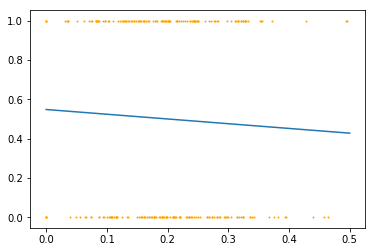

In [16]:
A = np.array(list(dataAllTitleBodyRelation.cosine_title_text))
B = np.array(list(dataAllTitleBodyRelation.veracity))

from sklearn.linear_model import LinearRegression
linearRegressionBodyRelation = LinearRegression(fit_intercept=True)
linearRegressionBodyRelation.fit(A[:, np.newaxis], B)

xfit = np.linspace(0, 0.5, 1000)
yfit = linearRegressionBodyRelation.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyRelation.coef_[0])
print("Model intercept:", linearRegressionBodyRelation.intercept_)
print("R2 score:", linearRegressionBodyRelation.score(A[:, np.newaxis], B))


Title and Text relation (calculated via cosine similarity) does not appear to be highly correlated with the text veracity

### Body - length

Model slope:     2.8672921260228005e-05
Model intercept: 0.41180985978637996
R2 score: 0.04612397796223433


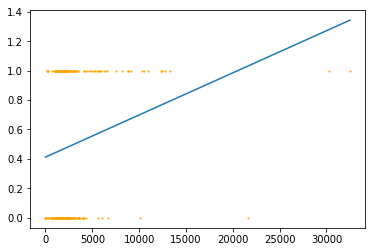

In [17]:
dataAllBodyLength = dataAll.copy()
for index, row in dataAllBodyLength.iterrows():
    textLength = len(row['text'])
    dataAllBodyLength.at[index, 'text_length'] = textLength


import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
linearRegressionBodyLength = LinearRegression(fit_intercept=True)

A = np.array(list(dataAllBodyLength.text_length))
B = np.array(list(dataAllBodyLength.veracity))

linearRegressionBodyLength.fit(A[:, np.newaxis], B)

xfit = np.linspace(-1, max(dataAllBodyLength.text_length), 1000)
yfit = linearRegressionBodyLength.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyLength.coef_[0])
print("Model intercept:", linearRegressionBodyLength.intercept_)
print("R2 score:", linearRegressionBodyLength.score(A[:, np.newaxis], B))

In [18]:
for index, row in dataTrain.iterrows():
    textLength = len(row['text'])
    dataTrain.at[index, 'text_length'] = textLength

for index, row in dataTest.iterrows():
    textLength = len(row['text'])
    dataTest.at[index, 'text_length'] = textLength

from sklearn import linear_model
# from sklearn import linear_model

logClassifierBodyLength = linear_model.LogisticRegression(solver='liblinear', C=17/1000, random_state=111)
logClassifierBodyLength.fit(dataTrain['text_length'].values.reshape(-1, 1), dataTrain['veracity'].values)

predicted = logClassifierBodyLength.predict(dataTest['text_length'].values.reshape(-1, 1))

from sklearn import metrics
print(metrics.accuracy_score(dataTest['veracity'].values.reshape(-1, 1), predicted))

0.7105263157894737


In [19]:
def DATAMINERS_getBodyLengthScore(length): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(length).reshape(-1, 1)
    predicted = logClassifierBodyLength.predict(x)
    predicedProb = logClassifierBodyLength.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProb)

print(DATAMINERS_getBodyLengthScore(12000))

0.20395870093748913


### Body - Grammar Check

In [20]:
#https://pypi.org/project/language-check/

import language_check

def calculateGrammarErrorsCount(text):
    tool = language_check.LanguageTool('en-US')
    #text = u'A sentence with a error in the Hitchhiker’s Guide to the Galaxy'
    errors = tool.check(text)
    return len(errors)

#calculateNumGrammarErrors("Helo you!")

In [21]:
dataTrainGrammar = dataTrain.copy()
dataTestGrammar = dataTest.copy()
dataAllGrammar = dataAll.copy()

for index, row in dataTrainGrammar.iterrows():
    dataTrainGrammar.at[index, 'grammar_errors_count'] = calculateGrammarErrorsCount(row['title']) + calculateGrammarErrorsCount(row['text'])

for index, row in dataTestGrammar.iterrows():
    dataTestGrammar.at[index, 'grammar_errors_count'] = calculateGrammarErrorsCount(row['title']) + calculateGrammarErrorsCount(row['text'])
    
for index, row in dataAllGrammar.iterrows():
    dataAllGrammar.at[index, 'grammar_errors_count'] = calculateGrammarErrorsCount(row['title']) + calculateGrammarErrorsCount(row['text'])
    
dataTrainGrammar.head()

,authors,canonical_link,images,source,text,title,url,veracity,text_length,grammar_errors_count
0,"[Jack Shafer, Burgess Everett, Seung Min Kim, ...",http://www.politico.com/story/2016/09/zika-fun...,[http://static.politico.com/ae/2d/1a0119fa45b8...,http://politi.co,"""I would encourage our colleagues across the a...",McConnell punts budget vote to buy time for deal,http://politi.co/2cksDqD,1,5702.0,19.0
1,"[Colin Taylor, Grant Stern, Brett Bose, Natali...",http://occupydemocrats.com/2016/09/21/massive-...,[http://occupydemocrats.com/wp-content/uploads...,http://occupydemocrats.com,12k SHARES SHARE THIS STORY\n\nMassive protest...,Massive Protests Erupt In North Carolina After...,http://occupydemocrats.com/2016/09/21/massive-...,1,928.0,2.0
2,[],http://rightwingnews.com/top-news/famous-dog-k...,[http://rightwingnews.com/wp-content/uploads/2...,http://rightwingnews.com,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,1,2297.0,12.0
3,[],NaN,NaN,,The University of North Dakota is investigatin...,'Locked the black bitch out': White students u...,NaN,1,1112.0,6.0
4,"[Jack Shafer, Robert Strauss]",http://www.politico.com/magazine/story/2016/09...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://politi.co,"As my 25th wedding anniversary approached, I t...",Worst. President. Ever.,http://politi.co/2cGdput,1,12463.0,20.0


Model slope:     0.006070454331972062
Model intercept: 0.42093233232606386
R2 score: 0.048057763461445524


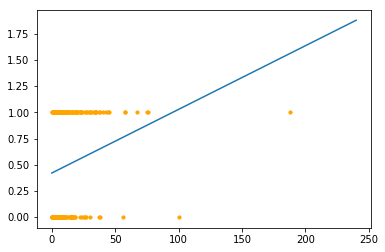

In [22]:
A = np.array(list(dataAllGrammar.grammar_errors_count))
B = np.array(list(dataAllGrammar.veracity))

linearRegressionBodyGrammar = LinearRegression(fit_intercept=True)
linearRegressionBodyGrammar.fit(A[:, np.newaxis], B)

xfit = np.linspace(0, len(A), len(A))
yfit = linearRegressionBodyGrammar.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=10, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyGrammar.coef_[0])
print("Model intercept:", linearRegressionBodyGrammar.intercept_)
print("R2 score:", linearRegressionBodyGrammar.score(A[:, np.newaxis], B))

By the graphic, we can see that there is no clear relation between grammar errors and text veracity. If it weren't by some outliers, we would get a almost flat a horizontal line.

### Body - Sentiment

I will be using Vader to do sentiment analysis

In [23]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rsc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
dataTrainSentiment = dataTrain.copy()
dataTestSentiment = dataTest.copy()
columnsToRemove = ['authors', 'canonical_link', 'images', 'title', 'source','url']
dataTrainSentiment = dataTrainSentiment.drop(columns = columnsToRemove)
dataTestSentiment = dataTestSentiment.drop(columns = columnsToRemove)


def addSentiment(sentence):
    ss = sid.polarity_scores(sentence)
    sValue = ss["compound"]
    sName = "neutral"
    if sValue > 0.0: 
        sName = "positive"
    elif sValue < 0.0:
        sName = "negative"
    return sValue


for index, row in dataTrainSentiment.iterrows():
    dataTrainSentiment.at[index, 'sentiment'] = addSentiment(row['text'])
    
dataTrainSentiment.head()

,text,veracity,text_length,sentiment
0,"""I would encourage our colleagues across the a...",1,5702.0,0.8910
1,12k SHARES SHARE THIS STORY\n\nMassive protest...,1,928.0,-0.9452
2,Famous dog killed in spot she waited a year fo...,1,2297.0,-0.9474
3,The University of North Dakota is investigatin...,1,1112.0,0.2732
4,"As my 25th wedding anniversary approached, I t...",1,12463.0,-0.9712


Model slope:     -0.002326980984717965
Model intercept: 0.4997920505077912
R2 score: 1.5769950133526223e-05


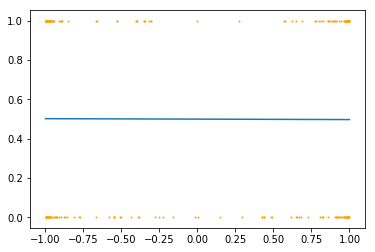

In [25]:
A = np.array(list(dataTrainSentiment.sentiment))
B = np.array(list(dataTrainSentiment.veracity))

linearRegressionBodySentiment = LinearRegression(fit_intercept=True)
linearRegressionBodySentiment.fit(A[:, np.newaxis], B)

xfit = np.linspace(-1, 1, 1000)
yfit = linearRegressionBodySentiment.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodySentiment.coef_[0])
print("Model intercept:", linearRegressionBodySentiment.intercept_)
print("R2 score:", linearRegressionBodySentiment.score(A[:, np.newaxis], B))

As we had to the Liar Liar dataset, the PolitiFact dataset does not show correlation between the text sentiment with the text veracity

### Body - Words Frequency

In [26]:
from ipynb.fs.full.m_wordfrequency import WordFrequency
wordFrequency = WordFrequency()

Word Frequency Model Trained - accuracy:   0.599053


In [27]:
def DATAMINERS_getWordFrequencyScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    binaryValue, probValue = wordFrequency.predict(text)
    return (1 - float(probValue))

print(DATAMINERS_getWordFrequencyScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.5104703891221564


### Source Reputation

In [28]:
import pandas as pd
dataFakeNewsSites = pd.read_csv("data/politifact-fakenews-sites.csv")
dataFakeNewsSites.head()

,site name,type of site,registration
0,16wmpo.com,imposter site,"scottsdale, ariz. **"
1,24online.news,imposter site,"panama, pa. **"
2,24wpn.com,fake news,"veles, macedonia"
3,24x365live.com,fake news,"kobenhavn, denmark"
4,247newsmedia.com,fake news,"kumanovo, macedonia"


In [29]:
dataFakeNewsSites['type of site'].unique()

array(['imposter site', 'fake news', 'parody site', 'some fake stories'],
      dtype=object)

As we can see, the sources are classified in different categories. Almost are all fake (fake news, parody,..) except the category 'some fake stories'. So let's hot encode those categories as 1 for fake news and 0.5 for some fake news.

In [30]:
for index, row in dataFakeNewsSites.iterrows():
    score = 1
    if (row['type of site'] == 'some fake stories'):
        score = 0.5
    dataFakeNewsSites.at[index, 'fake_score'] = score

dataFakeNewsSites.head()

,site name,type of site,registration,fake_score
0,16wmpo.com,imposter site,"scottsdale, ariz. **",1.0
1,24online.news,imposter site,"panama, pa. **",1.0
2,24wpn.com,fake news,"veles, macedonia",1.0
3,24x365live.com,fake news,"kobenhavn, denmark",1.0
4,247newsmedia.com,fake news,"kumanovo, macedonia",1.0


In [31]:
def DATAMINERS_getSourceReputationScore(source): # return between 0 and 1, being 0 = True,  1 = Fake
    if (source == ""):
        return 0
    d = dataFakeNewsSites[dataFakeNewsSites['site name'].str.match(source)]
    if (d['fake_score'].empty):
        return 0
    return int(d['fake_score'].values)


DATAMINERS_getSourceReputationScore('24wpn')

1

# FINAL COMBINED MODEL

In [32]:
# import warnings
# warnings.filterwarnings('ignore')

def isFakeNews(text, headline="", numAuthors = 0, source = "", party =""):
    accur = [0.84, 0.56, 0.98, 0.71, 0.6, 1] # using the (normalized) accuracy as weigths
    w = [float(i)/sum(accur) for i in accur]
    sumW = 0
    prob = []
    prob.append(w[0] * DATAMINERS_getAuthorScore(numAuthors))
    sumW += w[0]
    if ( (headline != "") & (party != "")):
        prob.append(w[1] * DATAMINERS_getPartyAffiliationScore(headline, party))
        sumW += w[1]
    if (headline != ""):
        prob.append(w[2] * DATAMINERS_getClickbaitScore(headline))
        sumW += w[2]
    prob.append(w[3] * DATAMINERS_getBodyLengthScore(len(text)))
    sumW += w[3]
    prob.append(w[4] * DATAMINERS_getWordFrequencyScore(text))
    sumW += w[4]
    if (party != ""):
        prob.append(w[5] * DATAMINERS_getSourceReputationScore(source))
        sumW += w[5]
    
    probTotal = sum(prob[0:len(prob)]) / sumW
    return probTotal
    
result = isFakeNews("Yesterday, the Brazilian soccer team won the world cup by defeating Argentina", "World Cup ends", 1, "cnn.com", "republican")

if result > 0.5:
    print("is FAKE NEWS!!!")
else:
    print("it is NOT fake news!!!")
            

it is NOT fake news!!!


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Performance analysis 

In [33]:
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)
    if ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1
        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("accuracy=", (truePos/(truePos+falseNeg)))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

truePos= 17
trueNeg= 6
falsePos= 2
falseNeg= 13
accuracy= 0.5666666666666667


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

If we add some error margin, let's say 10p.p to make our model only trust the results beyong that margin, we have:
    

In [34]:
errorMargin = 0.10
ignored = 0
truePos = 0
trueNeg = 0
falsePos = 0
falseNeg = 0
for index, row in dataTest.iterrows():
    text = row['text']
    headline= row['title']
    numAuthors = len(row['authors'])
    source = row['source']
    party = ""
    if 'party' in dataTest.columns:
        party = row['party']
    pred = isFakeNews(text, headline, numAuthors, source, party)

    if (abs(0.5 - pred) < errorMargin):
        ignored += 1
    elif ((row['veracity'] == 1) &  (pred < 0.5) ):
        truePos += 1
    elif ((row['veracity'] == 0) & (pred >= 0.5) ):
        trueNeg += 1
    elif ((row['veracity'] == 1) &  (pred >= 0.5) ):
        falsePos += 1            
    elif ((row['veracity'] == 0) &  (pred < 0.5) ):
        falseNeg += 1

        
print("truePos=", truePos)
print("trueNeg=", trueNeg)
print("falsePos=", falsePos)
print("falseNeg=", falseNeg)
print("ignored=", ignored)
print("accuracy=", (truePos/(truePos+falseNeg)))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

truePos= 14
trueNeg= 5
falsePos= 1
falseNeg= 4
ignored= 14
accuracy= 0.7777777777777778


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand